# LAB 2 MOS: Modelo Avanzado

- Samuel Augusto Hernandez 202213772
- Tomas Alberto Rodriguez 2022128686

## Problema 1: Distribucion optima de recursos en una mision humanitaria

### Preprocesamiento de datos

Los recursos se miden por toneladas para el peso. Se pasara a kilogramos para manejar correctamente el fraccionamiento de estos.
Para manejar los equipo medicos, se definira por cantidad de fracciones posibles. Solo se puede cargar 300kg juntos, no es mas divisible que eso. Por lo tanto, hay 66 unidades de equipo medico (se ignora el resto, que son 200kg y no se pueden enviar por si solos)

In [120]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np

t = 1000
recursos = {
    'Alimentos': {'valor': 50, 'peso': 15*t, 'volumen': 8},
    'Medicinas': {'valor': 100, 'peso': 5*t, 'volumen': 2},
    'Agua': {'valor': 60, 'peso': 18*t, 'volumen': 12},
    'Mantas': {'valor': 40, 'peso': 10*t, 'volumen': 6}
}
equipo = {'valor': 120, 'unidades': 66, 'volumen': 8}
aviones = {
    'A1': {'peso_max': 30*t, 'volumen_max': 25},
    'A2': {'peso_max': 42*t, 'volumen_max': 30},
    'A3': {'peso_max': 50*t, 'volumen_max': 35},
    
}

### Definicion del modelo matematico

#### Conjuntos

Recursos: $$ R = \{R1,R_2,R_3,R_4\}$$
$$ \forall i \in R$$
Recurso equipo medico: $$ E = \{E_1\}$$

Aviones: $$ A = \{A_1,A_2,A_3\}$$
$$ \forall j \in A$$

#### Parametros
Aviones:
Capacidad en kg de cada avion
$$ W_j: \forall j \in A$$
Capacidad en m^3 de cada avion
$$ V_j: \forall j \in A$$

Recursos:
peso disponible de cada recurso 
$$ w_i: \forall i \in R$$
volumen disponible de cada recurso 
$$ v_i: \forall i \in R$$
valor de cada recurso
$$ val_i: \forall i \in R$$

Equipo medico:

U: unidades de equipo medico disponible para transportar

V_e: Valor de transportar el equipo medico

#### Variables de decision

Kilogramos de recurso i que viajan en el avion j
$$ x_{ij} \ge 0 \in N$$

Unidades de equipos medico que viajan en el avion j
$$ y_{j} \ge 0 \in N$$

Valor que indica si el avión j lleva equipo medico
$$ z_{j} \in {0,1} $$

#### Funcion objetivo

$$ MAX(\sum_{i\in R} \sum_{j\in A} x_{ij} \cdot val_i / w_i + \sum_{j\in A} y{j} * V_e / U)$$

La fracción de valor que se transporta de cada recurso en cada avion (se maximiza)

#### Restricciones

Disponibilidad de cada recurso: No se mandan mas kilogramos de los que se tienen de cada recurso, ni mas unidades de equipo medico

$$ \sum_{j\in A} x_{ij} \leq w_i \ , \forall i \in R$$
$$ \sum_{j\in A}y_{j} \leq U \$$

Capacidad de los aviones: Tanto en peso como volumen

$$ (\sum_{i\in R} x_{ij}) + y_{j} \cdot 300 \leq W_j , \forall j \in A$$
$$ (\sum_{i\in R} x_{ij} \cdot v_i / w_i) + (y_{j}/U) * 10   \leq V_j , \forall j \in A$$

No medicinas en avion 1:

$$ x_{2,1} = 0 $$

Incompatibilidad de agua y equipo medicos:

$$ x_{3,j} \leq (1-z_{j}) \cdot W_j , \forall j \in A $$

Presencia de equipo medico

$$ y_{j} \leq U \cdot z_{j} , \forall j \in A $$

#### Tipo de problema


### Codigo en pyomo

In [121]:
model = ConcreteModel()

# Conjuntos y parametros

model.R = Set(initialize=['Alimentos', 'Medicinas', 'Agua', 'Mantas'])
model.A = Set(initialize=['A1', 'A2', 'A3'])

# Variables de decision

model.x = Var(model.R, model.A, domain=NonNegativeIntegers)
model.y = Var(model.A, domain=NonNegativeIntegers)
model.z = Var(model.A, domain=Binary)

# Funcion objetivo

def obj_rule(model):
    return sum(model.x[i, j] * recursos[i]['valor'] / recursos[i]['peso'] for i in model.R for j in model.A) + \
           sum(model.y[j] * equipo['valor'] / equipo['unidades'] for j in model.A)

model.obj = Objective(rule=obj_rule, sense=maximize)

# Restricciones

model.restriccion_disponibilidad = ConstraintList()
for i in model.R:
    model.restriccion_disponibilidad.add(
        sum(model.x[i, j] for j in model.A) <= recursos[i]['peso']
    )
model.restriccion_disponibilidad_e = Constraint(expr=sum(model.y[j] for j in model.A) <= 66)

model.restriccion_peso = ConstraintList()
for j in model.A:
    model.restriccion_peso.add(
        sum(model.x[i, j] for i in model.R) + model.y[j]*300 <= aviones[j]['peso_max']
    )

model.restriccion_volumen = ConstraintList()
for j in model.A:
    model.restriccion_volumen.add(
        sum(model.x[i, j] * recursos[i]['volumen']/recursos[i]['peso'] for i in model.R) + (model.y[j]/66)*10 <= aviones[j]['volumen_max']
    )

model.restriccion_compatibilidad = Constraint(expr=model.x['Medicinas', 'A1'] == 0)

model.restriccion_incompatibilidad = ConstraintList()
for j in model.A:
    model.restriccion_incompatibilidad.add(
        model.x["Agua",j] <= (1 - model.z[j]) * aviones[j]["peso_max"]
    )

model.presencia_equipo = ConstraintList()
for j in model.A:
    model.presencia_equipo.add(
        model.y[j] <= equipo["unidades"] * model.z[j]
    ) 

# Solucionarlo
solver = SolverFactory('glpk')
solver.solve(model)


for v in model.component_objects(Var, active=True):
    print(f'{v}: {list(v.get_values().items())}')

for i in model.R:
    for j in model.A:
        print(f"x[{i}, {j}] = {model.x[i, j].value}")


x: [(('Alimentos', 'A1'), 200.0), (('Alimentos', 'A2'), 14800.0), (('Alimentos', 'A3'), 0.0), (('Medicinas', 'A1'), 0.0), (('Medicinas', 'A2'), 5000.0), (('Medicinas', 'A3'), 0.0), (('Agua', 'A1'), 0.0), (('Agua', 'A2'), 18000.0), (('Agua', 'A3'), 0.0), (('Mantas', 'A1'), 10000.0), (('Mantas', 'A2'), 0.0), (('Mantas', 'A3'), 0.0)]
y: [('A1', 66.0), ('A2', 0.0), ('A3', 0.0)]
z: [('A1', 1.0), ('A2', 0.0), ('A3', 0.0)]
x[Alimentos, A1] = 200.0
x[Alimentos, A2] = 14800.0
x[Alimentos, A3] = 0.0
x[Medicinas, A1] = 0.0
x[Medicinas, A2] = 5000.0
x[Medicinas, A3] = 0.0
x[Agua, A1] = 0.0
x[Agua, A2] = 18000.0
x[Agua, A3] = 0.0
x[Mantas, A1] = 10000.0
x[Mantas, A2] = 0.0
x[Mantas, A3] = 0.0



Asignación de Recursos por Avión:
Avión A1:
  - Recursos asignados: ['Alimentos', 'Mantas', 'Equipo Médico']
  - Peso utilizado: 103019800.0 kg
  - Volumen utilizado: 14.106666666666666 m³
Avión A2:
  - Recursos asignados: ['Alimentos', 'Medicinas', 'Agua']
  - Peso utilizado: 571000000.0 kg
  - Volumen utilizado: 21.893333333333334 m³
Avión A3:
  - Recursos asignados: []
  - Peso utilizado: 0 kg
  - Volumen utilizado: 0 m³

Valor total transportado: 370.0 USD


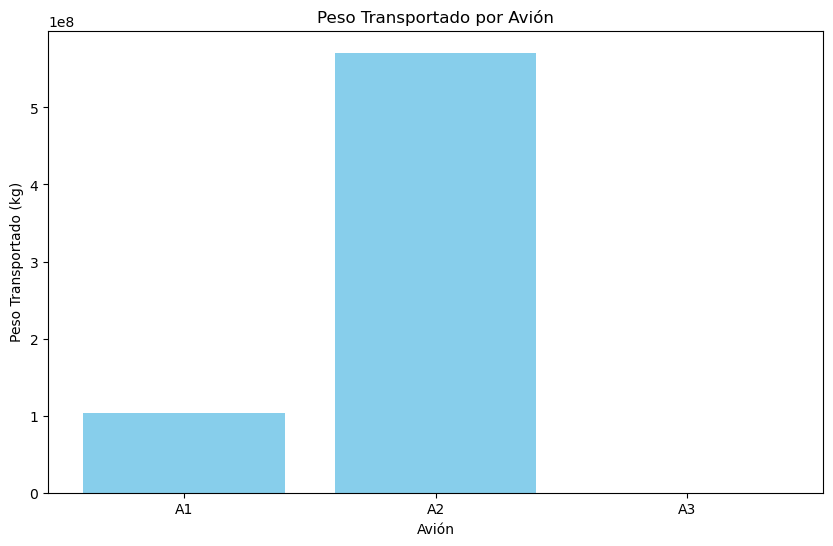

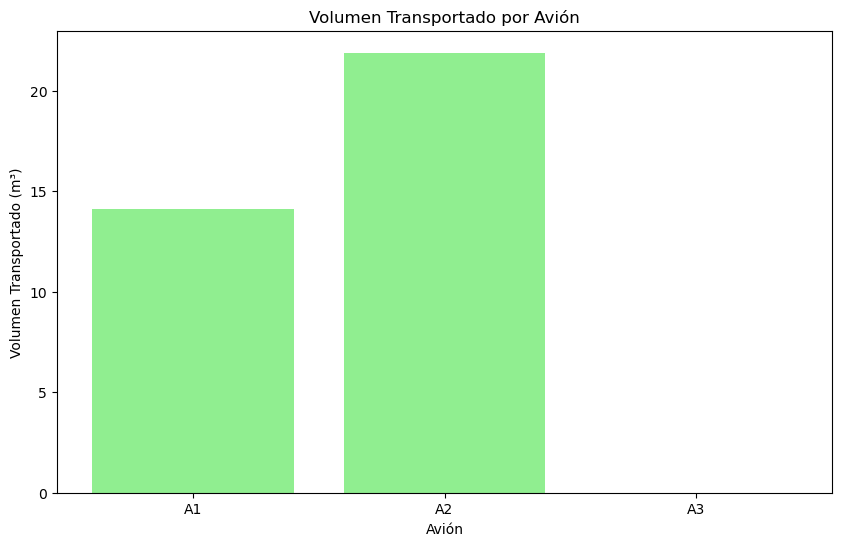

In [122]:
# Asignación de recursos a los aviones
asignacion_aviones = {j: {'Recursos': [], 'Peso Usado': 0, 'Volumen Usado': 0} for j in model.A}

# Recopilar los resultados
for i in model.R:
    for j in model.A:
        if model.x[i, j].value > 0:
            asignacion_aviones[j]['Recursos'].append(i)
            asignacion_aviones[j]['Peso Usado'] += model.x[i, j].value * recursos[i]['peso']
            asignacion_aviones[j]['Volumen Usado'] += model.x[i, j].value * recursos[i]['volumen'] / recursos[i]['peso']

# Incluir equipo médico en la asignación
for j in model.A:
    if model.y[j].value > 0:
        asignacion_aviones[j]['Recursos'].append('Equipo Médico')
        asignacion_aviones[j]['Peso Usado'] += model.y[j].value * 300
        asignacion_aviones[j]['Volumen Usado'] += model.y[j].value * equipo['volumen'] / equipo['unidades']

# Imprimir asignación
print("\nAsignación de Recursos por Avión:")
for avion, datos in asignacion_aviones.items():
    print(f"Avión {avion}:")
    print(f"  - Recursos asignados: {datos['Recursos']}")
    print(f"  - Peso utilizado: {datos['Peso Usado']} kg")
    print(f"  - Volumen utilizado: {datos['Volumen Usado']} m³")

# Valor total transportado
print(f"\nValor total transportado: {model.obj()} USD")

# Graficar la asignación de recursos
aviones = ['A1', 'A2', 'A3']
recursos_transportados = {avion: datos['Peso Usado'] for avion, datos in asignacion_aviones.items()}
volumen_transportado = {avion: datos['Volumen Usado'] for avion, datos in asignacion_aviones.items()}

# Gráfico de peso transportado
plt.figure(figsize=(10, 6))
plt.bar(aviones, recursos_transportados.values(), color='skyblue', label="Peso Transportado")
plt.title('Peso Transportado por Avión')
plt.xlabel('Avión')
plt.ylabel('Peso Transportado (kg)')
plt.show()

# Gráfico de volumen transportado
plt.figure(figsize=(10, 6))
plt.bar(aviones, volumen_transportado.values(), color='lightgreen', label="Volumen Transportado")
plt.title('Volumen Transportado por Avión')
plt.xlabel('Avión')
plt.ylabel('Volumen Transportado (m³)')
plt.show()

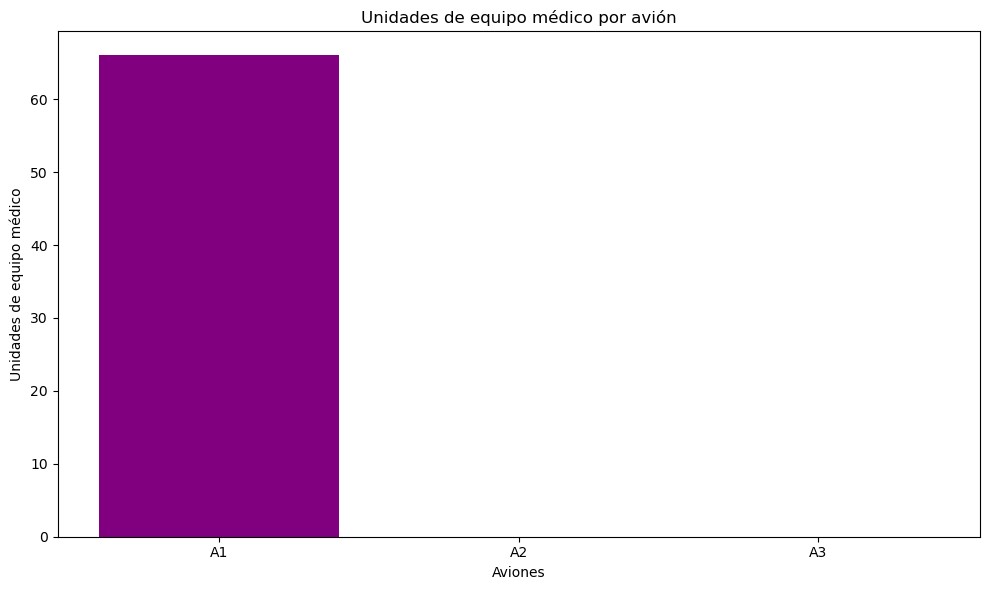

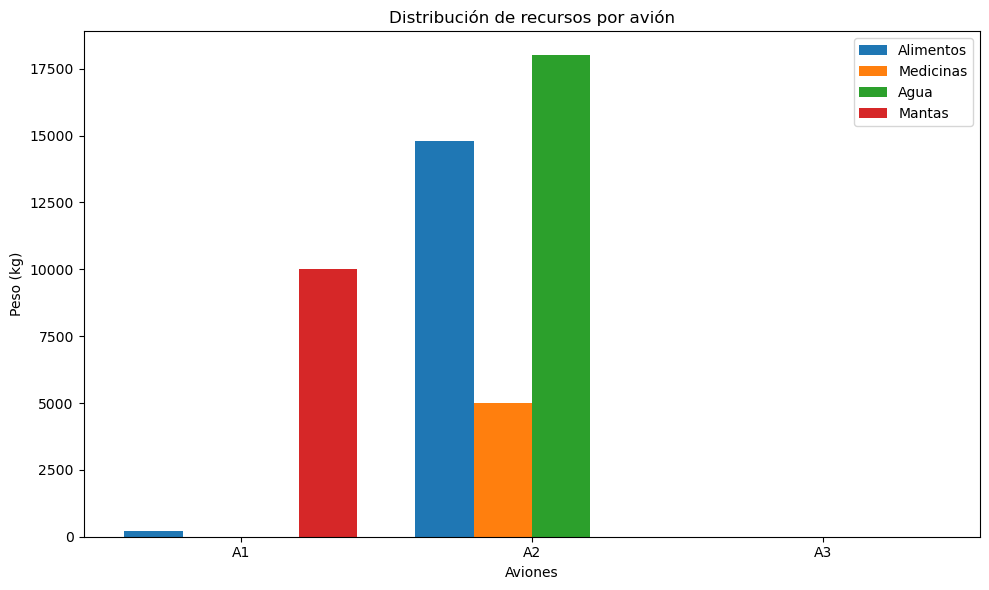

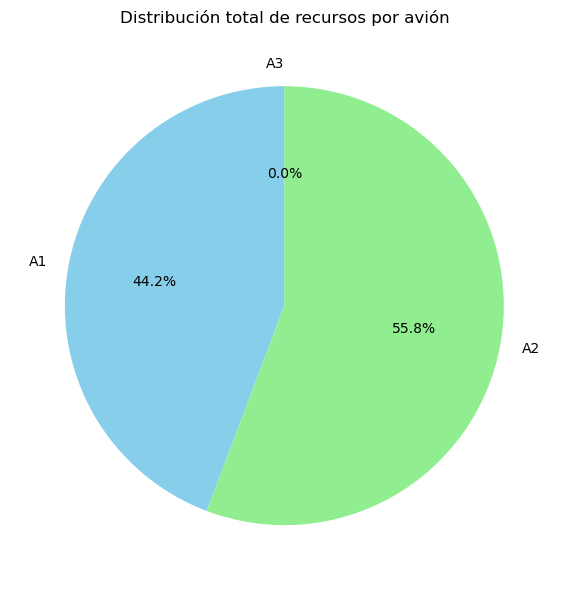

In [123]:
resource_weights = {avion: {recurso: model.x[recurso, avion].value for recurso in model.R} for avion in model.A}

# Resultados del equipo médico
y_results = {avion: model.y[avion].value for avion in model.A}

# 2. Unidades de equipo médico por avión
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(model.A, [y_results[avion] for avion in model.A], color='purple')
ax.set_xlabel('Aviones')
ax.set_ylabel('Unidades de equipo médico')
ax.set_title('Unidades de equipo médico por avión')
plt.tight_layout()

# 3. Distribución de recursos por avión (peso en kg)
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
indices = np.arange(len(model.A))

# Barra para cada recurso
for i, recurso in enumerate(model.R):
    ax.bar(indices + i * bar_width, [resource_weights[avion][recurso] for avion in model.A], bar_width, label=recurso)

ax.set_xlabel('Aviones')
ax.set_ylabel('Peso (kg)')
ax.set_title('Distribución de recursos por avión')
ax.set_xticks(indices + bar_width * 1.5)
ax.set_xticklabels(model.A)
ax.legend()
plt.tight_layout()


# 5. Distribución total de recursos y equipo médico
total_load = [sum([resource_weights[avion][recurso] for recurso in model.R]) + 300 * y_results[avion] for avion in model.A]
total_equipment = [y_results[avion] for avion in model.A]

fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(total_load, labels=model.A, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'lightcoral'])
ax.set_title('Distribución total de recursos por avión')
plt.tight_layout()

plt.show()

### Resultados y analisis

## Problema 2: Redes de transporte

### Definicion del modelo matematico

#### Conjuntos

Origen: $$ O = \{O1,O_2\}$$
$$ \forall j \in O$$

Destinos: $$ D = \{D_1,D_2,D_3,D_4,D_5,D_6\}$$
$$ \forall i \in D$$

#### Parametros
Origen:
Oferta en toneladas
$$ o_j: \forall j \in O$$

Destino:
demanda en toneladas 
$$ d_i: \forall i \in D$$

Costos:
$$ c_{ij}: \forall i\in D, \forall j\in O$$

#### Variables de decision

Toneladas a enviar de desde ciudad j a ciudad i
$$ x_{ij} \in N$$


#### Funcion objetivo

$$ MIN(\sum_{i\in D} \sum_{j\in O} x_{ij} \cdot c_{ij})$$

Valor de transportar en total (se minimiza)

#### Restricciones

Disponibilidad de cada origen: No se mandan mas toneladas de las que se tienen en bodega

$$ \sum_{i\in D} x_{ij} \leq o_j \ , \forall j \in O$$

Demanda de cada destino: Se manda exactamente la cantidad que se pide

$$ \sum_{j\in O} x_{ij} = d_i , \forall i \in D$$

Restricciones especificas:

$$ x_{1,1} = 0 $$

$$ x_{2,2} = 0 $$

No se envia de Bogota a Cali ni de Medellin a Barranquilla

$$ x_{ij} \ge 0 $$


#### Tipo de problema
LP


### Codigo en pyomo

In [124]:

destino = {
    'Cali': {'Bogota': 0, 'Medellin': 2.5, 'demanda': 125},
    'Barranquilla': {'Bogota': 2.5, 'Medellin': 0, 'demanda': 175},
    'Pasto': {'Bogota': 1.6, 'Medellin': 2.0, 'demanda': 225},
    'Tunja': {'Bogota': 1.4, 'Medellin': 1.0, 'demanda': 250},
    'Chia': {'Bogota': 0.8, 'Medellin': 1.0, 'demanda': 225},
    'Manizales': {'Bogota': 1.4, 'Medellin': 0.8, 'demanda': 200}
}
origen = {
    'Bogota': {'oferta': 550},
    'Medellin': {'oferta': 700}   
}

In [125]:
model2 = ConcreteModel()

# Conjuntos y parámetros
O = ['Bogota', 'Medellin']
D = ['Cali', 'Barranquilla', 'Pasto', 'Tunja', 'Chia', 'Manizales']
model2.O = origen.keys()
model2.D = destino.keys()

# Variables de decisión
model2.x = Var(model2.O, model2.D, domain=NonNegativeIntegers)

# Función objetivo
def objective_rule(model):
    return sum(model.x[j, i] * destino[i][j] for j in model.O for i in model.D)
model2.obj = Objective(rule=objective_rule, sense='minimize')

# Restricciones
def disponibilidad_rule(model, j):
    return sum(model.x[j, i] for i in model.D) <= origen[j]['oferta']
model2.disponibilidad = Constraint(model2.O, rule=disponibilidad_rule)

def demanda_rule(model, i):
    return sum(model.x[j, i] for j in model.O) == destino[i]['demanda']
model2.demanda = Constraint(model2.D, rule=demanda_rule)

model2.no_bogota_cali = Constraint(expr=model2.x['Bogota', 'Cali'] == 0)
model2.no_medellin_barranquilla = Constraint(expr=model2.x['Medellin', 'Barranquilla'] == 0)

# Resolver el modelo
solver = SolverFactory('glpk')
solver.solve(model2)

print(model2.obj())

1715.0


### Resultados y analisis

In [126]:
from tabulate import tabulate
# Tomar los datos para la tabla
data_enviado = [
    ['Cali', model2.x['Bogota', 'Cali'].value, model2.x['Medellin', 'Cali'].value],
    ['Barranquilla', model2.x['Bogota', 'Barranquilla'].value, model2.x['Medellin', 'Barranquilla'].value],
    ['Pasto', model2.x['Bogota', 'Pasto'].value, model2.x['Medellin', 'Pasto'].value],
    ['Tunja', model2.x['Bogota', 'Tunja'].value, model2.x['Medellin', 'Tunja'].value],
    ['Chia', model2.x['Bogota', 'Chia'].value, model2.x['Medellin', 'Chia'].value],
    ['Manizales', model2.x['Bogota', 'Manizales'].value, model2.x['Medellin', 'Manizales'].value]
]

total_bogota = sum(row[1] for row in data_enviado)
total_medellin = sum(row[2] for row in data_enviado)

data_enviado.append(['Totales', total_bogota, total_medellin])

# Definir los encabezados de la tabla
headers = ['Destino', 'Bogota', 'Medellin']

# Crear la tabla usando tabulate
table = tabulate(data_enviado, headers, tablefmt='grid')

# Imprimir la tabla en consola
print(table)

+--------------+----------+------------+
| Destino      |   Bogota |   Medellin |
+==============+==========+============+
| Cali         |        0 |        125 |
+--------------+----------+------------+
| Barranquilla |      175 |          0 |
+--------------+----------+------------+
| Pasto        |      225 |          0 |
+--------------+----------+------------+
| Tunja        |        0 |        250 |
+--------------+----------+------------+
| Chia         |      150 |         75 |
+--------------+----------+------------+
| Manizales    |        0 |        200 |
+--------------+----------+------------+
| Totales      |      550 |        650 |
+--------------+----------+------------+


In [127]:
# Cambio de oferta por 50 toneladas
origen = {
    'Bogota': {'oferta': 600},
    'Medellin': {'oferta': 650}   
}

# Resolver el modelo con cambio de ofertas
solver = SolverFactory('glpk')
solver.solve(model2)

# Tomar los datos para la tabla
data_enviado = [
    ['Cali', model2.x['Bogota', 'Cali'].value, model2.x['Medellin', 'Cali'].value],
    ['Barranquilla', model2.x['Bogota', 'Barranquilla'].value, model2.x['Medellin', 'Barranquilla'].value],
    ['Pasto', model2.x['Bogota', 'Pasto'].value, model2.x['Medellin', 'Pasto'].value],
    ['Tunja', model2.x['Bogota', 'Tunja'].value, model2.x['Medellin', 'Tunja'].value],
    ['Chia', model2.x['Bogota', 'Chia'].value, model2.x['Medellin', 'Chia'].value],
    ['Manizales', model2.x['Bogota', 'Manizales'].value, model2.x['Medellin', 'Manizales'].value]
]

total_bogota = sum(row[1] for row in data_enviado)
total_medellin = sum(row[2] for row in data_enviado)

data_enviado.append(['Totales', total_bogota, total_medellin])

# Definir los encabezados de la tabla
headers = ['Destino', 'Bogota', 'Medellin']

# Crear la tabla usando tabulate
table = tabulate(data_enviado, headers, tablefmt='grid')

# Imprimir la tabla en consola
print(table)

+--------------+----------+------------+
| Destino      |   Bogota |   Medellin |
+==============+==========+============+
| Cali         |        0 |        125 |
+--------------+----------+------------+
| Barranquilla |      175 |          0 |
+--------------+----------+------------+
| Pasto        |      225 |          0 |
+--------------+----------+------------+
| Tunja        |        0 |        250 |
+--------------+----------+------------+
| Chia         |      150 |         75 |
+--------------+----------+------------+
| Manizales    |        0 |        200 |
+--------------+----------+------------+
| Totales      |      550 |        650 |
+--------------+----------+------------+


Como se observa en ambas tablas, incluso al modificar las ofertas de los orígenes en 50 toneladas, el resultado de la asignación no varía. Esto tiene sentido, ya que en la solución inicial se tomaron 550 toneladas de Bogotá y 650 toneladas de Medellín, lo cual refleja la cantidad utilizada de Medellín en la distribución final. Como el total de la demanda y la oferta en cada ciudad es suficiente para satisfacer las restricciones, el modelo no tiene necesidad de cambiar la asignación, independientemente de las variaciones en las ofertas. Esto demuestra que, en este caso específico, las restricciones de oferta y demanda están equilibradas, y los cambios en las cantidades disponibles no afectan el resultado final.


El costo minimo de hacer los transportes de de 1750 USD, usando la distribución que se muestra en la tabla